# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


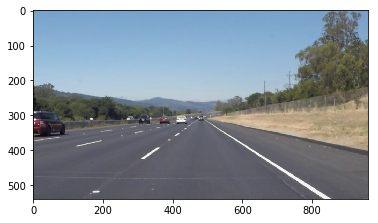

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #right lane line's parameters 
    positive_slope = []
    positive_slope_intercept = []
    
    #left lane line's parameters
    negative_slope = []
    negative_slope_intercept = []
    
    #points lying on the right side 
    positive_x = []
    negative_x = []
    
    #points lying on the left side
    positive_y = []
    negative_y = []
    
    #utility function for calculating slope)
    def slope(x1,y1,x2,y2):
        return((y2-y1)/(x2-x1))
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #calculating the slope of the given line
            m = np.round(slope(x1,y1,x2,y2),3)
            
            #calculating the intercept made by the line
            b = np.round(-m*x1+y1,3)
            
            if(m>0):
                #accumulate the points , slope , intercept into separate lists if slope is positive 
                positive_slope.append(m)
                positive_slope_intercept.append(b)
                positive_x.append(x1)
                positive_y.append(y1)
                positive_x.append(x2)
                positive_y.append(y2)
            else:
                #accumulate the points, slope, intercept into separate lists if slope is negative
                negative_slope.append(m)
                negative_slope_intercept.append(b)
                negative_x.append(x1)
                negative_y.append(y1)
                negative_x.append(x2)
                negative_y.append(y2)
                
    
    #calculating the respective averages of slope, intercept of positive(right) lane lines and negative(left) lane lines
    
    Avgpositive_slope = 0 if np.isnan(np.mean(positive_slope)) else np.mean(positive_slope)#if not np.mean is nan initialize with default value of 0 
    Avgpositive_slope_intercept = 0  if np.isnan(np.mean(positive_slope_intercept)) else np.mean(positive_slope_intercept) #if not np.mean is nan initialize with default value of 0
    Avgnegative_slope = 0 if np.isnan(np.mean(negative_slope)) else np.mean(negative_slope) #if not np.mean is nan initialize with default value of 0
    Avgnegative_slope_intercept = 0 if np.isnan(np.mean(negative_slope_intercept)) else np.mean(negative_slope_intercept)#if not np.mean is nan initialize with default value of 0


    #defining the vertical bounds for extrapolating lines
    y_min = int(img.shape[0]//1.7) 
    y_max = int(img.shape[0])
    
    
    #drawing lines onto the "img" 
    
    if Avgnegative_slope!=0:
        top_left_x = int((y_min - Avgnegative_slope_intercept)/Avgnegative_slope) # x value for the corresponding y_min
        bottom_left_x = int((y_max - Avgnegative_slope_intercept)/Avgnegative_slope)# x value for the corresponding y_max
        cv2.line(img,(top_left_x,y_min),(bottom_left_x,y_max),color,thickness)
        
    if Avgpositive_slope!=0:
        top_right_x = int((y_min - Avgpositive_slope_intercept)/Avgpositive_slope)# x value for the corresponding y_min
        bottom_right_x =int((y_max - Avgpositive_slope_intercept)/Avgpositive_slope)# x value for the corresponding y_max
        cv2.line(img,(bottom_right_x,y_max),(top_right_x,y_min),color,thickness)
                
                
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
number_of_images = len(os.listdir("test_images/"))
def software_pipeline(image):

    #canny algorithm's parameters
    low_threshold = 100
    high_threshold = 200
    
    #defining the size axes values (in image system(inverted y)))
    xsize = image.shape[1]
    ysize = image.shape[0]
    
    #ROI vertices
    left_bottom = (0.1*xsize,ysize)
    right_bottom = (0.96*xsize,ysize)
    left_top = (xsize//2.1,ysize//1.7)
    right_top = (xsize//1.8,ysize//1.7)
    vertices = np.array([[left_bottom,left_top,right_top,right_bottom]],dtype=np.int32)

    #grayscaling the image
    gray_image = grayscale(image)
    
    #usging gaussian blur to smoothen and remove the noise from the image
    smoothed_image = gaussian_blur(gray_image,3)
    
    #detecting the edges using canny algorithm(opencv canny function)
    edgeimage = canny(smoothed_image,low_threshold,high_threshold)
    
    #performing a masking operation to remove the all other edges except those in the ROI region
    masked_image = region_of_interest(img = edgeimage,vertices=vertices)
    
    #Detecting the lines using "Hough Transform" and then drawing lines over the image by averaging the parameters and 
    #then extrapolating the line over to merge into single long line.
    line_image = hough_lines(img=masked_image,max_line_gap=100,min_line_len=60,rho=3.5,theta=np.pi*2/180,threshold=120)
    
    #overlaying the line_image onto original image to give a visual perspective on how lines are detected.
    combined_image = weighted_img(img=line_image,initial_img=image,α=1.,β=0.8,γ=0)
    
    return combined_image
for index,image in enumerate(os.listdir("test_images/")):
    result_image = software_pipeline(mpimg.imread("test_images/"+image))
    cv2.imwrite(os.path.join("./test_images_output",str(index)+".jpg"),result_image)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    result = software_pipeline(image)
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.37 s, sys: 193 ms, total: 2.56 s
Wall time: 15.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [105]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:43<00:00, 15.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.79 s, sys: 681 ms, total: 7.47 s
Wall time: 45.4 s


In [106]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

782.088111111 -0.383777777778
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

782.088111111 -0.383777777778


  1%|          | 2/251 [00:00<00:19, 13.08it/s]

795.669090909 -0.435181818182
762.306 -0.33


  2%|▏         | 4/251 [00:00<00:18, 13.21it/s]

797.430538462 -0.453615384615
807.916375 -0.4696875


  2%|▏         | 6/251 [00:00<00:18, 13.22it/s]

804.215538462 -0.440923076923
801.0364 -0.4269


  3%|▎         | 8/251 [00:00<00:18, 13.39it/s]

798.7324 -0.4216
801.6614 -0.4298


  4%|▍         | 10/251 [00:00<00:17, 13.48it/s]

810.574 -0.455363636364
797.5039 -0.4249


  5%|▍         | 12/251 [00:00<00:17, 13.32it/s]

822.717333333 -0.509066666667
849.237833333 -0.575388888889


  6%|▌         | 14/251 [00:01<00:17, 13.39it/s]

805.251933333 -0.459066666667
793.723368421 -0.409210526316


  6%|▋         | 16/251 [00:01<00:17, 13.31it/s]

821.0484 -0.487733333333
825.615357143 -0.513785714286


  7%|▋         | 18/251 [00:01<00:17, 13.27it/s]

806.210181818 -0.451272727273
796.8675 -0.41825


  8%|▊         | 20/251 [00:01<00:17, 13.34it/s]

824.545928571 -0.512857142857
820.619933333 -0.511


  9%|▉         | 22/251 [00:01<00:17, 13.18it/s]

818.169333333 -0.5048
788.1863125 -0.441125


 10%|▉         | 24/251 [00:01<00:17, 13.28it/s]

807.483625 -0.4699375
818.998928571 -0.503214285714
768.581076923 -0.386230769231


 10%|█         | 26/251 [00:01<00:17, 12.75it/s]

792.922133333 -0.4208
792.262416667 -0.440583333333


 11%|█         | 28/251 [00:02<00:18, 12.02it/s]

813.416923077 -0.488230769231


 12%|█▏        | 30/251 [00:02<00:18, 12.25it/s]

806.213125 -0.4723125
823.8945 -0.5255


 13%|█▎        | 32/251 [00:02<00:17, 12.61it/s]

805.581466667 -0.4632
811.272769231 -0.483076923077


 14%|█▎        | 34/251 [00:02<00:16, 12.96it/s]

798.582166667 -0.452416666667
794.881153846 -0.453153846154


 14%|█▍        | 36/251 [00:02<00:16, 13.12it/s]

776.001909091 -0.399181818182
769.377333333 -0.368166666667


 15%|█▌        | 38/251 [00:02<00:16, 13.24it/s]

776.919307692 -0.389923076923
769.1096 -0.3744


 16%|█▌        | 40/251 [00:03<00:15, 13.32it/s]

767.275615385 -0.407692307692
786.981818182 -0.419090909091


 17%|█▋        | 42/251 [00:03<00:15, 13.38it/s]

771.807727273 -0.359909090909
798.545615385 -0.455230769231


 18%|█▊        | 44/251 [00:03<00:24,  8.53it/s]

804.776230769 -0.466307692308
810.790384615 -0.478307692308


 18%|█▊        | 46/251 [00:03<00:27,  7.37it/s]

766.554933333 -0.369133333333
799.122727273 -0.436363636364


 19%|█▉        | 48/251 [00:04<00:30,  6.57it/s]

772.4966 -0.417
786.9368 -0.400533333333


 20%|█▉        | 50/251 [00:04<00:32,  6.23it/s]

780.5292 -0.3935
801.452333333 -0.449166666667


 21%|██        | 52/251 [00:04<00:32,  6.14it/s]

814.154461538 -0.482538461538
798.5291 -0.4235


 22%|██▏       | 54/251 [00:05<00:32,  6.00it/s]

800.310166667 -0.447166666667
782.976615385 -0.373153846154


 22%|██▏       | 56/251 [00:05<00:33,  5.84it/s]

822.1999375 -0.51225
819.007142857 -0.498142857143


 23%|██▎       | 58/251 [00:06<00:33,  5.81it/s]

799.0451875 -0.430875
834.570294118 -0.543705882353


 24%|██▍       | 60/251 [00:06<00:33,  5.74it/s]

798.003058824 -0.421941176471
798.632083333 -0.449333333333


 25%|██▍       | 62/251 [00:06<00:32,  5.87it/s]

815.6042 -0.5012
779.580769231 -0.428230769231


 25%|██▌       | 64/251 [00:07<00:31,  5.87it/s]

773.8885 -0.4025
787.999538462 -0.466769230769


 26%|██▋       | 66/251 [00:07<00:31,  5.89it/s]

753.547 -0.3508
775.3175 -0.410416666667


 27%|██▋       | 68/251 [00:07<00:31,  5.77it/s]

754.37 -0.37775
750.964923077 -0.379538461538


 28%|██▊       | 70/251 [00:08<00:31,  5.71it/s]

742.468230769 -0.367307692308
771.263277778 -0.360888888889


 29%|██▊       | 72/251 [00:08<00:31,  5.71it/s]

798.358538462 -0.453846153846
772.82975 -0.4129375


 29%|██▉       | 74/251 [00:08<00:30,  5.87it/s]

775.5758 -0.40385
759.777727273 -0.337727272727


 30%|███       | 76/251 [00:09<00:30,  5.68it/s]

794.640583333 -0.43775
807.172411765 -0.468235294118


 31%|███       | 78/251 [00:09<00:31,  5.55it/s]

788.668 -0.409923076923
793.564272727 -0.426636363636


 32%|███▏      | 80/251 [00:09<00:30,  5.67it/s]

817.1268 -0.4484
734.703363636 -0.298909090909


 33%|███▎      | 82/251 [00:10<00:31,  5.38it/s]

740.882357143 -0.342142857143
813.61475 -0.451625


 33%|███▎      | 84/251 [00:10<00:30,  5.41it/s]

698.339818182 -0.237272727273
679.268666667 -0.209666666667


 34%|███▍      | 86/251 [00:10<00:30,  5.46it/s]

743.817941176 -0.283647058824
782.680916667 -0.4225


 35%|███▍      | 87/251 [00:11<00:34,  4.78it/s]

804.208285714 -0.444785714286


 35%|███▌      | 88/251 [00:11<00:37,  4.32it/s]

823.280230769 -0.495076923077


 35%|███▌      | 89/251 [00:11<00:40,  4.05it/s]

820.1488 -0.4752


 36%|███▌      | 90/251 [00:12<00:42,  3.78it/s]

859.302142857 -0.562928571429


 36%|███▋      | 91/251 [00:12<00:42,  3.77it/s]

848.6155 -0.524916666667


 37%|███▋      | 93/251 [00:12<00:38,  4.09it/s]

828.430230769 -0.487538461538
776.480166667 -0.34625


 38%|███▊      | 95/251 [00:13<00:32,  4.75it/s]

742.0716875 -0.2730625
822.817454545 -0.462181818182


 39%|███▊      | 97/251 [00:13<00:29,  5.13it/s]

803.9983125 -0.4333125
806.390666667 -0.467277777778


 39%|███▉      | 99/251 [00:13<00:28,  5.29it/s]

838.8056 -0.5119
789.885555556 -0.39


 40%|████      | 101/251 [00:14<00:27,  5.50it/s]

735.028142857 -0.356285714286
753.21075 -0.429875


 41%|████      | 103/251 [00:14<00:25,  5.82it/s]

685.554636364 -0.253363636364
738.106 -0.376428571429


 42%|████▏     | 105/251 [00:14<00:25,  5.73it/s]

816.19 -0.4985
691.452666667 -0.232333333333


 43%|████▎     | 107/251 [00:15<00:24,  5.87it/s]

712.6435 -0.1224
704.063142857 -0.119714285714


 43%|████▎     | 109/251 [00:15<00:25,  5.65it/s]

709.219555556 -0.0857777777778
643.0588 -0.0482


 45%|████▌     | 114/251 [00:16<00:25,  5.32it/s]

456.298 -0.034


 47%|████▋     | 118/251 [00:17<00:24,  5.40it/s]

573.588 -0.016
470.391 -0.031


 48%|████▊     | 120/251 [00:17<00:25,  5.19it/s]

683.99 -0.015
470.36 -0.031


 49%|████▉     | 123/251 [00:18<00:25,  5.01it/s]

478.636 -0.042


 49%|████▉     | 124/251 [00:18<00:24,  5.22it/s]

467.309 -0.027


 50%|█████     | 126/251 [00:18<00:24,  5.04it/s]

594.075 -0.0605
694.26 -0.035


 51%|█████     | 128/251 [00:19<00:24,  5.07it/s]

587.585 -0.035


 52%|█████▏    | 130/251 [00:19<00:23,  5.10it/s]

616.851 -0.0216666666667
668.984 -0.3515


 53%|█████▎    | 132/251 [00:20<00:24,  4.93it/s]

684.467 -0.20375


 53%|█████▎    | 133/251 [00:20<00:22,  5.18it/s]

642.29 -0.1628
664.624333333 -0.220666666667


 54%|█████▍    | 135/251 [00:20<00:22,  5.23it/s]

656.675 -0.091
596.5025 -0.2175


 55%|█████▍    | 137/251 [00:21<00:21,  5.37it/s]

613.871 -0.241
652.876 -0.307333333333


 55%|█████▌    | 139/251 [00:21<00:20,  5.48it/s]

610.98625 -0.134
680.459 -0.241166666667


 56%|█████▌    | 141/251 [00:21<00:21,  5.08it/s]

697.61525 -0.375
699.40775 -0.2895


 57%|█████▋    | 143/251 [00:22<00:20,  5.17it/s]

716.844875 -0.330625
689.155222222 -0.237888888889


 58%|█████▊    | 145/251 [00:22<00:20,  5.18it/s]

690.091363636 -0.302454545455
683.822416667 -0.243333333333


 59%|█████▊    | 147/251 [00:23<00:20,  5.17it/s]

707.529789474 -0.262578947368
733.698208333 -0.305416666667


 59%|█████▉    | 149/251 [00:23<00:20,  4.97it/s]

732.241074074 -0.23062962963


 60%|█████▉    | 150/251 [00:23<00:20,  4.95it/s]

748.151619048 -0.297428571429
760.815333333 -0.361


 61%|██████    | 152/251 [00:24<00:19,  5.08it/s]

814.783545455 -0.590909090909
796.346 -0.486923076923


 61%|██████▏   | 154/251 [00:24<00:19,  5.05it/s]

779.338636364 -0.471
815.2201 -0.604


 62%|██████▏   | 156/251 [00:24<00:18,  5.09it/s]

782.961076923 -0.461153846154
761.678 -0.390333333333


 63%|██████▎   | 158/251 [00:25<00:18,  5.00it/s]

771.2054 -0.4314


 63%|██████▎   | 159/251 [00:25<00:18,  4.92it/s]

785.338230769 -0.473153846154


 64%|██████▎   | 160/251 [00:25<00:18,  4.88it/s]

761.064666667 -0.394833333333


 64%|██████▍   | 161/251 [00:25<00:18,  4.84it/s]

798.531636364 -0.568909090909


 65%|██████▍   | 162/251 [00:26<00:17,  5.03it/s]

794.309333333 -0.535222222222
791.582461538 -0.537692307692


 65%|██████▌   | 164/251 [00:26<00:17,  5.08it/s]

801.4162 -0.5715
798.154666667 -0.558666666667


 66%|██████▌   | 166/251 [00:26<00:16,  5.10it/s]

802.646 -0.565375
772.092333333 -0.398666666667


 67%|██████▋   | 168/251 [00:27<00:17,  4.88it/s]

777.6911 -0.4187


 67%|██████▋   | 169/251 [00:27<00:16,  4.93it/s]

744.288583333 -0.322083333333
772.539214286 -0.385


 68%|██████▊   | 171/251 [00:27<00:16,  4.79it/s]

804.505785714 -0.484285714286


 69%|██████▊   | 172/251 [00:28<00:16,  4.90it/s]

793.705833333 -0.427416666667
789.244777778 -0.424222222222


 69%|██████▉   | 174/251 [00:28<00:15,  4.95it/s]

809.344733333 -0.483066666667
795.206 -0.446538461538


 70%|███████   | 176/251 [00:28<00:15,  4.75it/s]

794.951363636 -0.429363636364


 71%|███████   | 177/251 [00:29<00:14,  4.96it/s]

785.5619 -0.4013
796.16725 -0.443666666667


 71%|███████▏  | 179/251 [00:29<00:14,  4.86it/s]

781.314941176 -0.384941176471
799.054166667 -0.4435


 72%|███████▏  | 181/251 [00:29<00:14,  4.89it/s]

797.506727273 -0.435727272727
804.531666667 -0.456416666667


 73%|███████▎  | 183/251 [00:30<00:14,  4.71it/s]

793.8767 -0.4156


 73%|███████▎  | 184/251 [00:30<00:13,  4.93it/s]

786.5174 -0.401
785.1826 -0.3975


 74%|███████▍  | 186/251 [00:31<00:13,  4.94it/s]

810.112714286 -0.483857142857
770.471777778 -0.357888888889


 75%|███████▍  | 188/251 [00:31<00:13,  4.84it/s]

799.0769 -0.4185


 75%|███████▌  | 189/251 [00:31<00:12,  4.85it/s]

810.943714286 -0.454785714286
834.281625 

 76%|███████▌  | 190/251 [00:31<00:12,  4.87it/s]

-0.532


 76%|███████▌  | 191/251 [00:32<00:12,  4.62it/s]

825.789071429 -0.505214285714


 76%|███████▋  | 192/251 [00:32<00:12,  4.69it/s]

828.802571429 -0.511071428571
801.456

 77%|███████▋  | 193/251 [00:32<00:12,  4.67it/s]

 -0.413222222222


 77%|███████▋  | 194/251 [00:32<00:11,  4.77it/s]

816.322583333 -0.474833333333
772.353222222 

 78%|███████▊  | 195/251 [00:32<00:11,  4.92it/s]

-0.323333333333
803.884363636 -0.445090909091


 78%|███████▊  | 197/251 [00:33<00:10,  5.08it/s]

806.3326 -0.436
781.6214 -0.3583


 79%|███████▉  | 199/251 [00:33<00:10,  5.13it/s]

819.327444444 -0.481111111111
804.564923077 -0.436769230769


 80%|████████  | 201/251 [00:34<00:09,  5.29it/s]

811.56325 -0.46625
807.319 -0.448454545455


 81%|████████  | 203/251 [00:34<00:08,  5.36it/s]

793.4725 -0.378875
801.95425 -0.437625


 82%|████████▏ | 205/251 [00:34<00:08,  5.34it/s]

821.0996 -0.4606
828.89375 -0.49575


 82%|████████▏ | 207/251 [00:35<00:08,  5.48it/s]

817.7027 -0.4553
809.916727273 -0.452818181818


 83%|████████▎ | 209/251 [00:35<00:07,  5.54it/s]

825.715454545 -0.509090909091
826.986153846 -0.497615384615


 84%|████████▍ | 211/251 [00:35<00:07,  5.36it/s]

839.193866667 -0.508066666667
809.286222222 -0.423555555556


 85%|████████▍ | 213/251 [00:36<00:06,  5.56it/s]

821.516083333 -0.45125
815.788818182 -0.459909090909


 86%|████████▌ | 215/251 [00:36<00:06,  5.83it/s]

843.037923077 -0.526153846154
843.4486 -0.516333333333


 86%|████████▋ | 217/251 [00:36<00:05,  5.68it/s]

847.48375 -0.5325
877.457357143 -0.617357142857


 87%|████████▋ | 219/251 [00:37<00:06,  5.13it/s]

817.425333333 -0.449333333333
802.0885

 88%|████████▊ | 220/251 [00:37<00:05,  5.52it/s]

 -0.4271
780.8624 -0.3551


 88%|████████▊ | 222/251 [00:37<00:05,  5.60it/s]

810.587777778 -0.431444444444
803.008 -0.414888888889


 89%|████████▉ | 224/251 [00:38<00:04,  5.55it/s]

815.327222222 -0.435111111111
822.023545455 -0.476363636364


 90%|█████████ | 226/251 [00:38<00:04,  5.52it/s]

839.879818182 -0.505454545455
819.378 -0.443444444444


 91%|█████████ | 228/251 [00:38<00:04,  5.58it/s]

832.152777778 -0.499333333333
811.890636364 -0.425545454545


 92%|█████████▏| 230/251 [00:39<00:03,  5.35it/s]

838.601727273 -0.503636363636
831.03425 -0.489


 92%|█████████▏| 232/251 [00:39<00:03,  5.53it/s]

836.220071429 -0.528
810.565 -0.436947368421


 93%|█████████▎| 233/251 [00:39<00:03,  4.92it/s]

844.225923077 -0.535230769231


 93%|█████████▎| 234/251 [00:40<00:03,  4.45it/s]

827.530916667 -0.497


 94%|█████████▎| 235/251 [00:40<00:03,  4.11it/s]

840.760857143 -0.535285714286


 94%|█████████▍| 236/251 [00:40<00:03,  3.96it/s]

849.0115 -0.547857142857


 94%|█████████▍| 237/251 [00:41<00:03,  3.78it/s]

842.624071429 -0.539142857143


 95%|█████████▍| 238/251 [00:41<00:03,  3.70it/s]

837.200428571 -0.531


 96%|█████████▌| 240/251 [00:41<00:02,  4.27it/s]

814.207916667 -0.447416666667
845.146133333 -0.550133333333


 96%|█████████▋| 242/251 [00:42<00:01,  4.79it/s]

835.107466667 -0.507933333333
850.348727273 -0.560454545455


 97%|█████████▋| 244/251 [00:42<00:01,  5.26it/s]

816.576611111 -0.457944444444
836.182461538 -0.522384615385


 98%|█████████▊| 246/251 [00:42<00:00,  5.41it/s]

839.175384615 -0.529923076923
826.082428571 -0.482785714286


 99%|█████████▉| 248/251 [00:43<00:00,  5.56it/s]

790.498230769 -0.386230769231
791.00425 -0.376375


100%|█████████▉| 250/251 [00:43<00:00,  5.69it/s]

805.5094 -0.4338
800.759777778 -0.412


100%|██████████| 251/251 [00:43<00:00,  5.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.7 s, sys: 1.03 s, total: 13.7 s
Wall time: 47.5 s


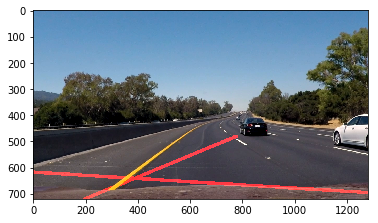

In [80]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [81]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))